<a href="https://colab.research.google.com/github/VishwasMore/SkimLit-Project/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit 

## The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6ab19473-f173-7431-3ff1-8353692c8989)


## Get the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.
We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all the file names in the target directory 
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [6]:
# Create a function to read the lines of a document 
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in training lines 
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look...


```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 491 ms, sys: 89.6 ms, total: 580 ms
Wall time: 581 ms


In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
#Put dict to dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Distribution of labels 

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

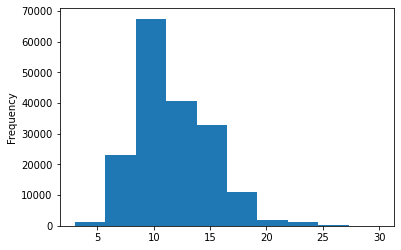

In [17]:
# lets chack the length of different lines 
train_df.total_lines.plot.hist();

### Get List of Sentences 

In [18]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making Numeric Labels (target)

In [20]:
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [21]:
# One Hot encode labels 

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy())

train_labels_one_hot

ValueError: ignored

In [25]:
# One Hot encode labels 

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
import tensorflow as tf

# turn it into tensords 
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels 

In [27]:
# Extract labels ("target" columns) and encode them into integers 

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [28]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))